# NSF Research Awards Abstracts - Exploratory Data Analysis (EDA)


## 1. Introduction
 In this analysis, we explore the NSF Research Awards Abstracts dataset to understand its structure
 and assess its suitability for unsupervised topic modeling. We will analyze text characteristics,
 explore word frequencies, and evaluate different embedding representations for clustering.

## 2. Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import logging
import warnings
import xml.etree.ElementTree as ET
from sentence_transformers import SentenceTransformer
import tiktoken
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] %(message)s')

# Configure paths
RAW_DATA_PATH = '../data/raw/'
PROCESSED_DATA_PATH = '../data/processed/'

# Ensure NLTK data is available
nltk.download('punkt')
nltk.download('stopwords')


c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eddym\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eddym\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 3. Data Loading and Preprocessing


In [2]:

def safe_strip(node):
    return node.text.strip() if (node is not None and node.text) else None

def parse_nsf_xml(file_path):
    file_name = os.path.basename(file_path)
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
    except ET.ParseError:
        return None

    award_node = root.find('Award')
    if award_node is None:
        return None

    award_title = safe_strip(award_node.find('AwardTitle'))
    abstract = safe_strip(award_node.find('AbstractNarration'))
    award_id = safe_strip(award_node.find('AwardID'))
    if not award_id:
        award_id = file_name.replace('.xml', '')

    return {
        'award_id': award_id,
        'award_title': award_title,
        'abstract': abstract
    }

def read_all_xml(folder_path):
    records, failed_files, missing_abstract_files = [], [], []
    file_list = [f for f in os.listdir(folder_path) if f.lower().endswith('.xml')]

    if not file_list:
        logging.warning(f"No XML files found in folder: {folder_path}")
        return pd.DataFrame()

    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        record = parse_nsf_xml(file_path)

        if record:
            if not record['abstract']:
                missing_abstract_files.append(file_name)
            records.append(record)
        else:
            failed_files.append(file_name)

    df = pd.DataFrame(records)

    logging.info(f"Parsed {len(records)} file(s) successfully, {len(failed_files)} failed.")
    if missing_abstract_files:
        logging.warning(f"Files with missing abstracts: {missing_abstract_files}")
    return df

# Text preprocessing function
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return ' '.join(tokens)

# Load XML abstracts
df_abstracts = read_all_xml(RAW_DATA_PATH)
df_abstracts.dropna(subset=['abstract'], inplace=True)
preprocessed_abstracts = [preprocess_text(text) for text in df_abstracts['abstract']]



2025-01-15 00:24:56,676 [INFO] Parsed 13300 file(s) successfully, 0 failed.
2025-01-15 00:24:56,676 [WARNING] Files with missing abstracts: ['2001029.xml', '2001271.xml', '2001273.xml', '2001275.xml', '2001276.xml', '2001311.xml', '2001499.xml', '2001846.xml', '2002070.xml', '2002401.xml', '2002760.xml', '2002833.xml', '2002888.xml', '2002944.xml', '2003608.xml', '2004263.xml', '2006228.xml', '2007128.xml', '2007680.xml', '2010264.xml', '2010792.xml', '2011373.xml', '2012963.xml', '2013060.xml', '2013252.xml', '2013254.xml', '2013542.xml', '2013642.xml', '2013674.xml', '2013787.xml', '2015388.xml', '2015655.xml', '2016151.xml', '2016193.xml', '2016297.xml', '2016587.xml', '2016785.xml', '2019265.xml', '2019278.xml', '2019469.xml', '2019552.xml', '2019792.xml', '2020261.xml', '2021247.xml', '2022394.xml', '2023003.xml', '2023100.xml', '2024034.xml', '2024250.xml', '2026426.xml', '2026745.xml', '2027951.xml', '2028064.xml', '2028257.xml', '2030136.xml', '2030984.xml', '2031008.xml', '203

There are about 150 files that do not contain the required information in the abstract so those will be disregarded

## Exploratory Analysis

Top 20 Unigrams:
project: 41355
research: 36050
using: 21176
students: 19456
support: 19314
data: 18460
award: 15994
broader: 15877
impacts: 15832
new: 15290
evaluation: 13827
intellectual: 13369
foundations: 13298
mission: 13233
nsfs: 13185
merit: 13143
review: 13114
criteria: 13046
reflects: 12967
deemed: 12928

Top 20 Bigrams:
broader impacts: 13559
intellectual merit: 13074
merit broader: 12914
evaluation using: 12912
support evaluation: 12910
award reflects: 12906
statutory mission: 12906
mission deemed: 12906
deemed worthy: 12906
worthy support: 12906
impacts review: 12906
reflects nsfs: 12903
nsfs statutory: 12903
using foundations: 12903
foundations intellectual: 12903
review criteria: 12895
graduate students: 2269
machine learning: 2179
undergraduate students: 2069
project aims: 2062

Top 20 Trigrams:
intellectual merit broader: 12914
merit broader impacts: 12910
statutory mission deemed: 12906
mission deemed worthy: 12906
deemed worthy support: 12906
worthy support evaluation

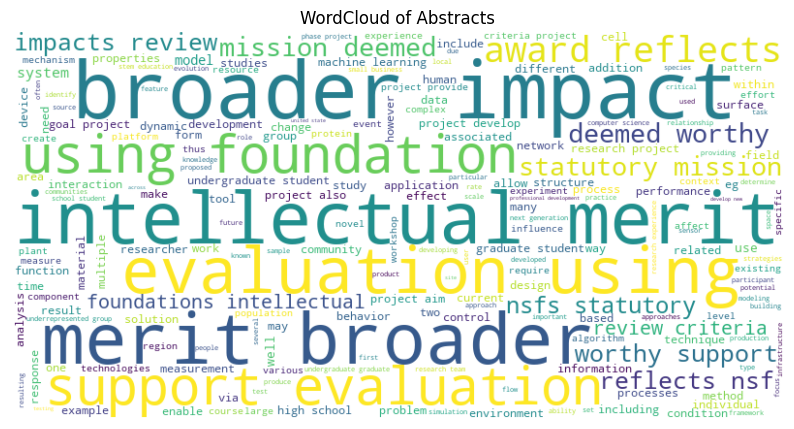

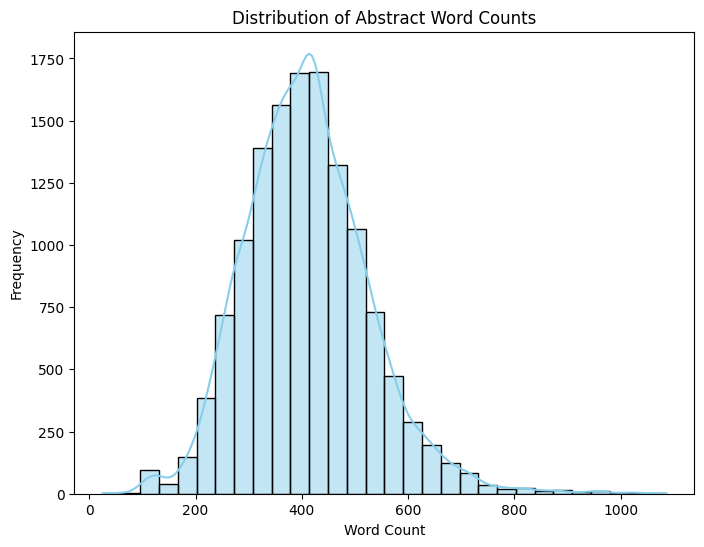


Descriptive Statistics for Abstract Word Counts:
count    13159.000000
mean       410.110723
std        116.765440
min         25.000000
25%        332.000000
50%        405.000000
75%        479.000000
max       1086.000000
Name: word_count, dtype: float64


In [3]:
# 4. Exploratory Text Analysis

# Unigram, Bigram, and Trigram Frequency Analysis
def token_frequency_analysis(texts, n=1, top_n=20):
    from nltk import ngrams, FreqDist
    all_tokens = ' '.join(texts).split()
    ngram_tokens = ngrams(all_tokens, n) if n > 1 else all_tokens
    freq_dist = FreqDist(ngram_tokens)
    common_ngrams = freq_dist.most_common(top_n)
    for ngram, freq in common_ngrams:
        print(f"{' '.join(ngram) if isinstance(ngram, tuple) else ngram}: {freq}")
    return common_ngrams

# Unigram Frequency
print("Top 20 Unigrams:")
token_frequency_analysis(preprocessed_abstracts, n=1)

# Bigram Frequency
print("\nTop 20 Bigrams:")
token_frequency_analysis(preprocessed_abstracts, n=2)

# Trigram Frequency
print("\nTop 20 Trigrams:")
token_frequency_analysis(preprocessed_abstracts, n=3)

# Word Cloud Visualization
def plot_wordcloud(texts):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        stopwords=set(stopwords.words('english')),
        width=800, height=400
    ).generate(' '.join(texts))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('WordCloud of Abstracts')
    plt.show()

plot_wordcloud(preprocessed_abstracts)

# Descriptive Statistics of Abstract Lengths
df_abstracts['word_count'] = df_abstracts['abstract'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
sns.histplot(df_abstracts['word_count'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Abstract Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

print("\nDescriptive Statistics for Abstract Word Counts:")
print(df_abstracts['word_count'].describe())

Notably, the words 'nsf','grant','award','proposal','research','project', 'merit', 'broader', 'impacts', 'using', 'intellectual', 'review' are stopwords in this specific case so they will be removed in order to proceed with the embedding analysis and avoid the embedding techinques to get confused over this words. Also, the abstracts words count follow a Gaussian like distribution which is friendly with most ML models, still no decision can be made out of this information yet, further analysis with embeddings will provide better understanding of the data

In [4]:
    # Base stopwords
custom_stopwords = ['nsf','grant','award','proposal','research','project', 'merit', 'broader', 'impacts', 'using', 'intellectual', 'review', 'criteria', 'deemed']
base_stops = set(stopwords.words('english'))
base_stops = base_stops.union(set(custom_stopwords))

## Embedding analysis

In [5]:
def get_tfidf_embeddings(texts):
    vectorizer = TfidfVectorizer(max_features=5000, stop_words=list(base_stops))
    return vectorizer.fit_transform(texts).toarray()

tfidf_embeddings = get_tfidf_embeddings(preprocessed_abstracts)

# Load or generate GTE Large embeddings
if os.path.exists(os.path.join(PROCESSED_DATA_PATH, 'embeddings_GTE-Large.npy')):
    gte_embeddings = np.load(os.path.join(PROCESSED_DATA_PATH, 'embeddings_GTE-Large.npy'))
else:
    model_gte = SentenceTransformer('thenlper/gte-large')
    gte_embeddings = model_gte.encode(preprocessed_abstracts, show_progress_bar=True)
    np.save(os.path.join(PROCESSED_DATA_PATH, 'embeddings_GTE-Large.npy'), gte_embeddings)

# Load or generate OpenAI embeddings
if os.path.exists(os.path.join(PROCESSED_DATA_PATH, 'embeddings_OpenAI.npy')):
    openai_embeddings = np.load(os.path.join(PROCESSED_DATA_PATH, 'embeddings_OpenAI.npy'))
else:
    client = OpenAI(api_key=api_key)
    encoder = tiktoken.get_encoding("cl100k_base")
    max_tokens = 8000

    embeddings_list = []

    for idx, text in enumerate(df_abstracts['abstract']):
        if not isinstance(text, str):
            text = str(text) if text else ""

        tokens = encoder.encode(text)

        if len(tokens) <= max_tokens:
            response = client.embeddings.create(
                input=text,
                model="text-embedding-3-small"
            )
            emb = response.data[0].embedding
            embeddings_list.append(emb)
        else:
            chunk_embeddings = []
            start = 0
            while start < len(tokens):
                end = min(start + max_tokens, len(tokens))
                chunk_tokens = tokens[start:end]
                chunk_text = encoder.decode(chunk_tokens)

                response = client.embeddings.create(
                    input=chunk_text,
                    model="text-embedding-3-small"
                )
                chunk_emb = np.array(response.data[0].embedding, dtype=np.float32)
                chunk_embeddings.append(chunk_emb)

                start += max_tokens

            if len(chunk_embeddings) > 0:
                doc_emb = np.mean(chunk_embeddings, axis=0)
            else:
                doc_emb = np.zeros(1536, dtype=np.float32)

            embeddings_list.append(doc_emb)

        if (idx + 1) % 50 == 0:
            print(f"Processed {idx+1} / {len(df_abstracts)} abstracts")

    openai_embeddings = np.array(embeddings_list, dtype=np.float32)
    np.save(os.path.join(PROCESSED_DATA_PATH, 'embeddings_OpenAI.npy'), openai_embeddings)


## 6. Dimensionality Reduction & Visualization

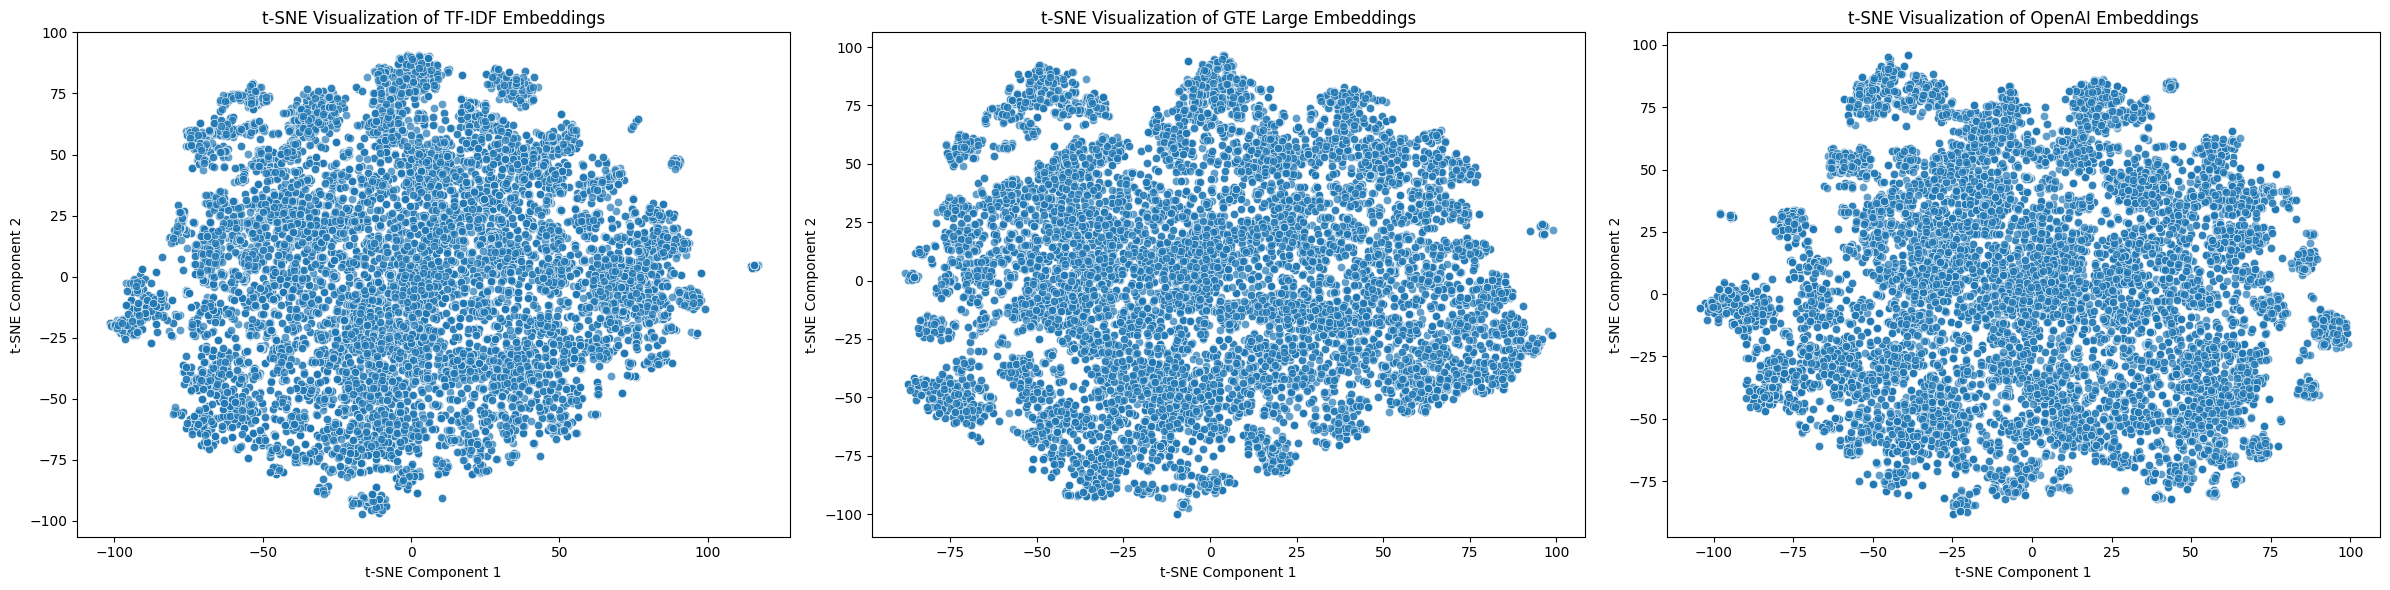

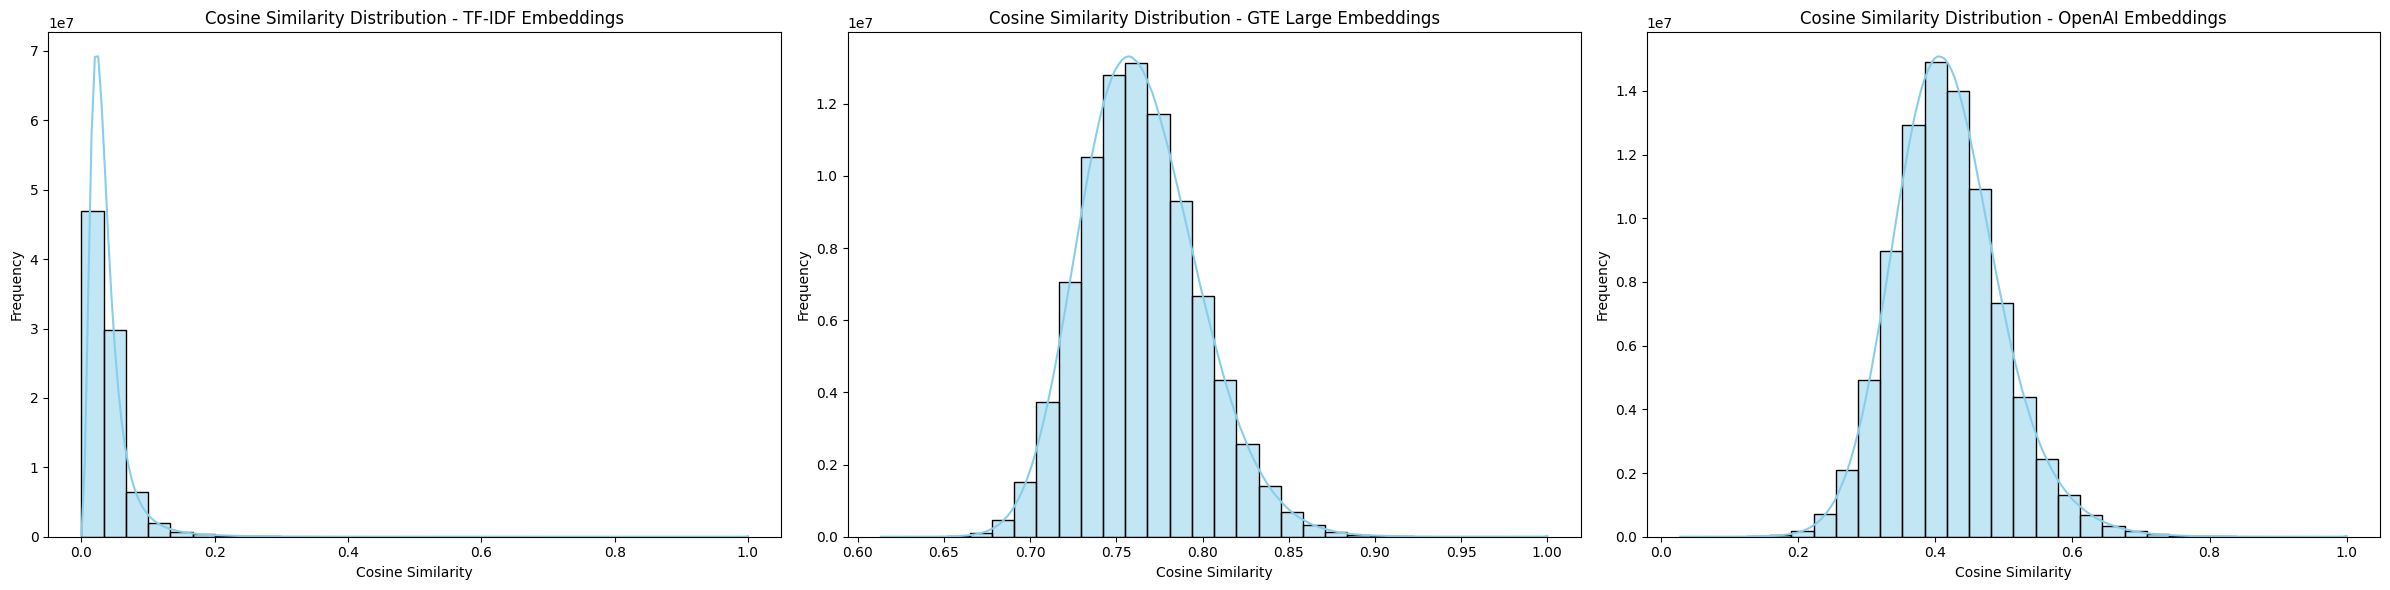

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

# Define t-SNE visualization function
def plot_tsne(embeddings, title, ax, perplexity=30, random_state=42):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state, learning_rate='auto', init='pca')
    reduced_embeddings = tsne.fit_transform(embeddings)
    sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], alpha=0.7, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')

# Visualize TF-IDF, GTE Large, and OpenAI embeddings side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
plot_tsne(tfidf_embeddings, 't-SNE Visualization of TF-IDF Embeddings', axes[0])
plot_tsne(gte_embeddings, 't-SNE Visualization of GTE Large Embeddings', axes[1])
plot_tsne(openai_embeddings, 't-SNE Visualization of OpenAI Embeddings', axes[2])
plt.tight_layout()
plt.show()

# Cosine similarity distributions
def plot_cosine_similarity_distribution(embeddings, title, ax):
    cosine_sim = cosine_similarity(embeddings)
    upper_triangle_indices = np.triu_indices_from(cosine_sim, k=1)
    cosine_sim_values = cosine_sim[upper_triangle_indices]
    
    sns.histplot(cosine_sim_values, bins=30, kde=True, color='skyblue', ax=ax)
    ax.set_title(f'Cosine Similarity Distribution - {title}')
    ax.set_xlabel('Cosine Similarity')
    ax.set_ylabel('Frequency')

# Plot cosine similarity distributions side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
plot_cosine_similarity_distribution(tfidf_embeddings, 'TF-IDF Embeddings', axes[0])
plot_cosine_similarity_distribution(gte_embeddings, 'GTE Large Embeddings', axes[1])
plot_cosine_similarity_distribution(openai_embeddings, 'OpenAI Embeddings', axes[2])
plt.tight_layout()
plt.show()

With these graphs we can note that the data is densly packed and highly homogeneous. 
1. TFIDF with additional stop words: Data is skewed to the left concentered near 0 indicating sparse and highly orthogonal vectors with very little semantic overlap this implies that it is capturing surface-level features, making dense clustering difficult.
2. GTE-Large: Tightly clustered around 0.75 with narrow Gaussian-like distribution. Suggests that most embeddings are semantically similar, making it harder to distinguish distinct clusters. High uniformity in similarity might lead to over-clustering or single large clusters.
3. OpenAI Small Embeddings: Slightly more spread out than GTE-Large, still a unimodal distribution with a peak around 0.4. Unimodality still implies low cluster efficiency possible since clusters are not clearly separable. Soft clustering method might work

### Statistical analysis
Now, we can get the Hopkins statistic and state the hypothesis that if H = 0.5 , then our data is unlikely to have statistically significant clusters, therefore dataset is too complex or other kind of embeddings or techniques are in order, or to pick advanced cluster analysis. In the other hand, we can run a bayesian process of optimization in the number of clusters that can be formed with these embeddings using as target the silhouette score of the data distributions.

In [10]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from pyclustertend import hopkins
from skopt import BayesSearchCV



# Function to calculate Hopkins statistic
def calculate_hopkins_statistic(embeddings, sample_size=1000):
    return hopkins(embeddings, sample_size)


# Calculate Hopkins statistics
tfidf_hopkins_statistic = calculate_hopkins_statistic(tfidf_embeddings)
gte_hopkins_statistic = calculate_hopkins_statistic(gte_embeddings)
openai_hopkins_statistic = calculate_hopkins_statistic(openai_embeddings)



print(f"TF-IDF Hopkins Statistic: {tfidf_hopkins_statistic}")
print(f"GTE Large Hopkins Statistic: {gte_hopkins_statistic}")
print(f"OpenAI Hopkins Statistic: {openai_hopkins_statistic}")


# Function to perform Bayesian optimization for KMeans
def bayesian_optimization(embeddings, n_iter=50):
    kmeans = KMeans(random_state=42)
    search_space = {'n_clusters': (2, 50)}
    opt = BayesSearchCV(kmeans, search_space, n_iter=n_iter, cv=3, random_state=42)
    opt.fit(embeddings)
    best_n_clusters = opt.best_params_['n_clusters']
    labels = KMeans(n_clusters=best_n_clusters, random_state=42).fit_predict(embeddings)
    best_score = silhouette_score(embeddings, labels)
    return best_n_clusters, best_score

# Perform Bayesian optimization for each embedding
tfidf_best_n_clusters, tfidf_best_score = bayesian_optimization(tfidf_embeddings)
gte_best_n_clusters, gte_best_score = bayesian_optimization(gte_embeddings)
openai_best_n_clusters, openai_best_score = bayesian_optimization(openai_embeddings)

# Print the optimal number of clusters and the corresponding silhouette scores
print(f"TF-IDF Optimal Number of Clusters: {tfidf_best_n_clusters}, Silhouette Score: {tfidf_best_score}")
print(f"GTE Large Optimal Number of Clusters: {gte_best_n_clusters}, Silhouette Score: {gte_best_score}")
print(f"OpenAI Optimal Number of Clusters: {openai_best_n_clusters}, Silhouette Score: {openai_best_score}")

TF-IDF Hopkins Statistic: 0.04438271699393167
GTE Large Hopkins Statistic: 0.21339822440372216
OpenAI Hopkins Statistic: 0.21111355481249364
TF-IDF Optimal Number of Clusters: 50, Silhouette Score: 0.024408120398211428
GTE Large Optimal Number of Clusters: 50, Silhouette Score: 0.03976888209581375
OpenAI Optimal Number of Clusters: 50, Silhouette Score: 0.04375576600432396


As we can see, the Hopkins statistic indicated that the data is not randomly distributed and can be used for clusters. And based on the silhouettes scores, the best option is to cluster with the OpenAI Embeddings at 50 clusters (so far). In the model selection part we will firther experiment with different cluster numbers, methods and metrics to get to the optimal clusterization of our data